In [1]:
## imports
# read
# drop arival rate of delayed flights
# make the barrier or threshold for classification
# break up into num and cat 
# x and target y as delay rate 
# scale encode and transform
# make knn filter 5 and weight as distance
# make pipeline
# fit the model on training data
# predict and confusion matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_score,
    precision_recall_curve
)


In [2]:
df = pd.read_csv("Airline_Delay_Cause.csv") # Read data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171666 non-null  int64  
 1   month                171666 non-null  int64  
 2   carrier              171666 non-null  object 
 3   carrier_name         171666 non-null  object 
 4   airport              171666 non-null  object 
 5   arr_flights          171426 non-null  float64
 6   arr_del15            171223 non-null  float64
 7   carrier_ct           171426 non-null  float64
 8   weather_ct           171426 non-null  float64
 9   nas_ct               171426 non-null  float64
 10  security_ct          171426 non-null  float64
 11  late_aircraft_ct     171426 non-null  float64
 12  arr_cancelled        171426 non-null  float64
 13  arr_diverted         171426 non-null  float64
 14  arr_delay            171426 non-null  float64
 15  carrier_delay    

,year,month,carrier,carrier_name,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,89.0,13.0,2.25,1.60,3.16,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,62.0,10.0,2.73,1.18,1.80,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,92.0,22.0,7.76,0.00,2.96,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


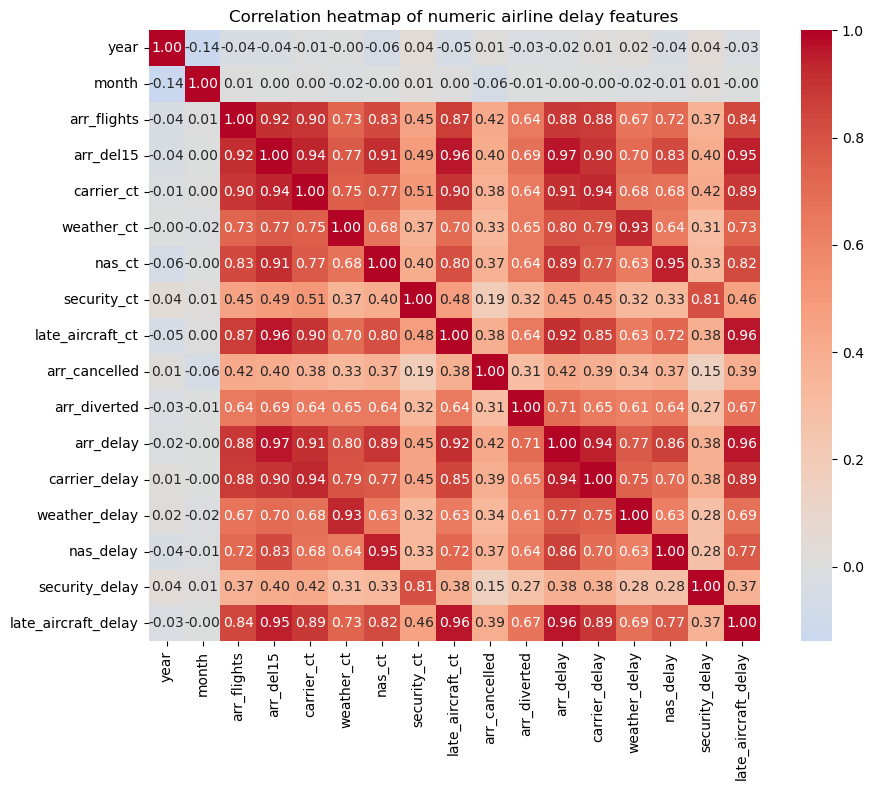

In [3]:
num_cols = df.select_dtypes(include=["number"])
corr = num_cols.corr()

# heat map of all features
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,          # show numbers
    fmt=".2f",           # 2 decimal places
    center=0,
    square=True
)
plt.title("Correlation heatmap of numeric airline delay features")
plt.tight_layout()
plt.show()

In [4]:
df = df.dropna(subset=["arr_flights", "arr_del15"]) # drop features to get the delay rate

In [5]:
# calculate the delay rate if less than 20% 0 and if greater that 20% it is 1
df["arr_delay_rate"] = df["arr_del15"] / df["arr_flights"]
df["delay_15_label"] = (df["arr_delay_rate"] >= 0.20).astype(int)


In [6]:
# select features that pass leak test
feature_cols_num = ["year", "month", "arr_flights", "arr_cancelled", "arr_diverted"]
feature_cols_cat = ["carrier", "carrier_name", "airport"]


In [7]:
# x and target set
X = df[feature_cols_num + feature_cols_cat]
y = df["delay_15_label"]

In [8]:
# scale encode and transform 
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [9]:
# make the KNN classifier model 
knn = KNeighborsClassifier(n_neighbors=7, weights="distance") # determines high low off 5 closest points 

In [10]:
# # Model with neighbours set to 10 test
# knn = KNeighborsClassifier(n_neighbors=10, weights="distance") 

In [11]:
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("knn", knn),
])

In [13]:
start_knn = time.time()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
end_knn = time.time()
time_knn = end_knn - start_knn

Training + prediction time (s): 152.4586
[[25478  5819]
 [ 9076 10994]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     31297
           1       0.65      0.55      0.60     20070

    accuracy                           0.71     51367
   macro avg       0.70      0.68      0.68     51367
weighted avg       0.70      0.71      0.70     51367



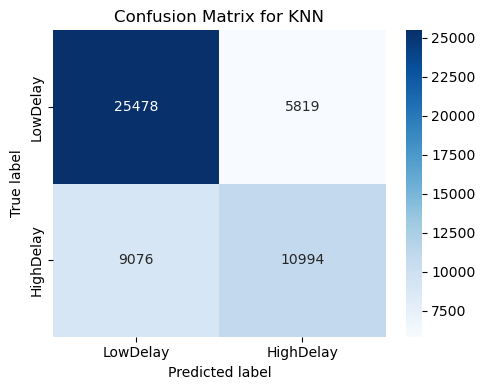

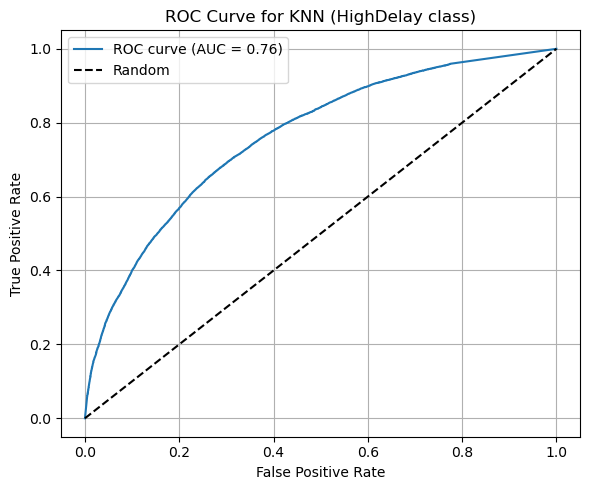

In [17]:
print("Training + prediction time (s): %.4f" % time_knn)
y_pred = clf.predict(X_test)

# roc and auc graph
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
# confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["LowDelay", "HighDelay"],
    yticklabels=["LowDelay", "HighDelay"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix for KNN")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for KNN (HighDelay class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

results = []

for k in [5, 6, 7, 8, 9]:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn_clf_k = Pipeline(steps=[
        ("preprocess", preprocess),
        ("knn", knn),
    ])
    knn_clf_k.fit(X_train, y_train)
    y_pred_k = knn_clf_k.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    
    # focus on HighDelay (class 1) precision/recall/F1
    report = classification_report(y_test, y_pred_k, output_dict=True)
    prec1 = report["1"]["precision"]
    rec1 = report["1"]["recall"]
    f11 = report["1"]["f1-score"]
    
    results.append({
        "k": k,
        "accuracy": acc,
        "precision_1": prec1,
        "recall_1": rec1,
        "f1_1": f11,
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


   k  accuracy  precision_1  recall_1      f1_1
0  5  0.707439     0.644321  0.560787  0.599659
1  6  0.711274     0.652075  0.559641  0.602333
2  7  0.710028     0.653899  0.547783  0.596155
3  8  0.712033     0.659110  0.544694  0.596464
4  9  0.709950     0.658610  0.534928  0.590360


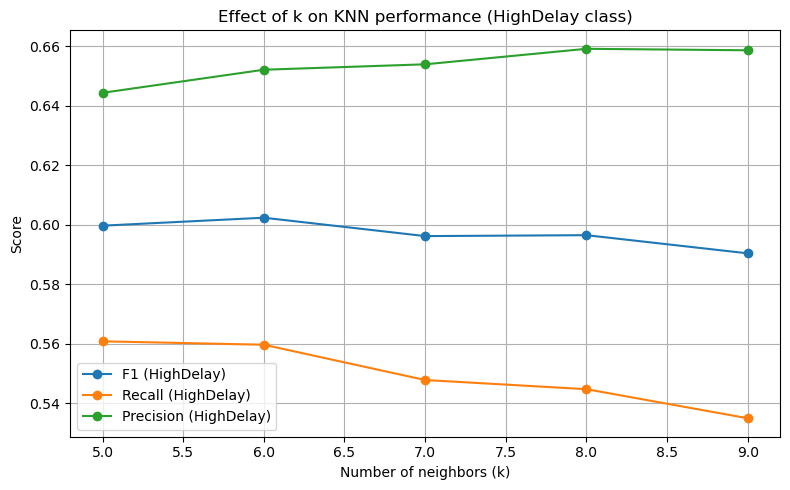

In [16]:

plt.figure(figsize=(8, 5))
plt.plot(results_df["k"], results_df["f1_1"], marker="o", label="F1 (HighDelay)")
plt.plot(results_df["k"], results_df["recall_1"], marker="o", label="Recall (HighDelay)")
plt.plot(results_df["k"], results_df["precision_1"], marker="o", label="Precision (HighDelay)")

plt.xlabel("Number of neighbors (k)")
plt.ylabel("Score")
plt.title("Effect of k on KNN performance (HighDelay class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

